In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from pyspark.sql.functions import sum, countDistinct, count, col, split, explode
from pyspark.sql.types import StructType, StructField, StringType, FloatType

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Apache Spark
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz -O spark-3.1.2-bin-hadoop2.7.tgz

# verifying the file size and checksum
!ls -lh spark-3.1.2-bin-hadoop2.7.tgz
!echo "7f640111a35d139b6a2fa55bc92c3fbc5b8d6d202ed3a03f1523ef0638a2e0fc  spark-3.1.2-bin-hadoop2.7.tgz" | sha256sum -c -

# extracting the tar file only if the checksum is correct
!tar xf spark-3.1.2-bin-hadoop2.7.tgz
!pip install -q findspark


-rw-r--r-- 1 root root 215M May 24  2021 spark-3.1.2-bin-hadoop2.7.tgz
spark-3.1.2-bin-hadoop2.7.tgz: FAILED
sha256sum: WARNING: 1 computed checksum did NOT match


In [ ]:
import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

In [ ]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')

# Navigate to the data directory
os.chdir('/content/drive/MyDrive/GA/project-5/data')

Mounted at /content/drive


In [ ]:
spark = SparkSession.builder.appName("DonationDataProcessing").getOrCreate()

# defining the schema based on the FEC file description
schema = StructType([
    StructField("committee_id", StringType(), True),
    StructField("amendment_indicator", StringType(), True),
    StructField("report_type", StringType(), True),
    StructField("primary_general_indicator", StringType(), True),
    StructField("image_number", StringType(), True),
    StructField("transaction_type", StringType(), True),
    StructField("entity_type", StringType(), True),
    StructField("donor_name", StringType(), True),
    StructField("city", StringType(), True),
    StructField("state", StringType(), True),
    StructField("zip_code", StringType(), True),
    StructField("employer", StringType(), True),
    StructField("occupation", StringType(), True),
    StructField("transaction_date", StringType(), True),
    StructField("transaction_amount", FloatType(), True),
    StructField("other_id", StringType(), True),
    StructField("candid_id", StringType(), True),
    StructField("transaction_id", StringType(), True),
    StructField("file_num", StringType(), True),
    StructField("memo_cd", StringType(), True),
    StructField("memo_text", StringType(), True),
    StructField("sub_id", StringType(), True)
])


In [ ]:
def load_donations(file_path):
    return spark.read.csv(file_path, sep='|', schema=schema)

In [ ]:
years = [2016, 2018, 2020, 2022]
all_yearly_donations = []

for year in years:
    donation_file_path = f'/content/drive/MyDrive/GA/project-5/data/{year}/itcont.txt'
    yearly_donations_spark_df = load_donations(donation_file_path)

    # keeping only the first committee ID when there are multiple
    yearly_donations_spark_df = yearly_donations_spark_df.withColumn("committee_id", split(col("committee_id"), ",")[0])

    yearly_aggregated_spark_df = yearly_donations_spark_df.groupBy("committee_id").agg(
        sum("transaction_amount").alias("total_donations"),
        countDistinct("donor_name").alias("unique_donors"),
        count("transaction_amount").alias("num_donations")
    )
    yearly_aggregated_pandas_df = yearly_aggregated_spark_df.toPandas()
    yearly_aggregated_pandas_df['year'] = year
    all_yearly_donations.append(yearly_aggregated_pandas_df)

# combining all aggregated donations
combined_aggregated_donations_df = pd.concat(all_yearly_donations, ignore_index=True)

# loading the main DataFrame
senate_races_path = '/content/drive/MyDrive/GA/project-5/data/data/senate_races/dataframe_all_close_senate_races.xlsx'
senate_races_df = pd.read_excel(senate_races_path)

# keeping only the first committee ID in the main DataFrame when there are multiple
senate_races_df['committee_id'] = senate_races_df['committee_id'].apply(lambda x: x.split(',')[0])

# merging with the main DataFrame
merged_senate_races_df = senate_races_df.merge(combined_aggregated_donations_df, on=['committee_id', 'year'], how='left')

# saving the updated DataFrame
output_file_path = '/content/drive/MyDrive/GA/project-5/data/data/senate_races/updated_dataframe_all_close_senate_races_with_donations.xlsx'
merged_senate_races_df.to_excel(output_file_path, index=False)

print(merged_senate_races_df.head())

  state        candidate  year committee_id party  result  vote_share  \
0    AK   Lisa Murkowski  2022    C00384529     R       1        43.4   
1    AK   Kelly Tshibaka  2022    C00774570     R       0        42.6   
2    AZ       Mark Kelly  2022    C00696526     D       1        51.4   
3    AZ    Blake Masters  2022    C00784165     R       0        46.5   
4    GA  Raphael Warnock  2022    C00736876     D       1        49.4   

   incumbent  total_donations  unique_donors  num_donations  
0          1        5470611.0           3491           6482  
1          0        3708691.0           4606          12621  
2          1       49436605.0          84539         647836  
3          0        9074038.0           8360          22549  
4          1      101098954.0         175455        1079333  


In [ ]:
merged_senate_races_df.isna().sum()

,0
state,0
candidate,0
year,0
committee_id,0
party,0
result,0
vote_share,0
incumbent,0
total_donations,0
unique_donors,0


In [ ]:
all_aggregated_donations['total_donations'].sum()

37007981551.0

In [ ]:
all_aggregated_donations.describe()

,total_donations,unique_donors,num_donations,year
count,3.442800e+04,3.442800e+04,3.442800e+04,34428.000000
mean,1.074938e+06,6.778803e+02,5.094773e+03,2019.190717
std,1.844653e+07,1.286282e+04,1.922989e+05,2.207152
min,-1.109527e+06,0.000000e+00,1.000000e+00,2016.000000
25%,1.000000e+04,5.000000e+00,8.000000e+00,2018.000000
50%,5.325550e+04,2.800000e+01,5.200000e+01,2020.000000
75%,2.625000e+05,1.400000e+02,4.240000e+02,2022.000000
max,2.080785e+09,1.404116e+06,2.394467e+07,2022.000000


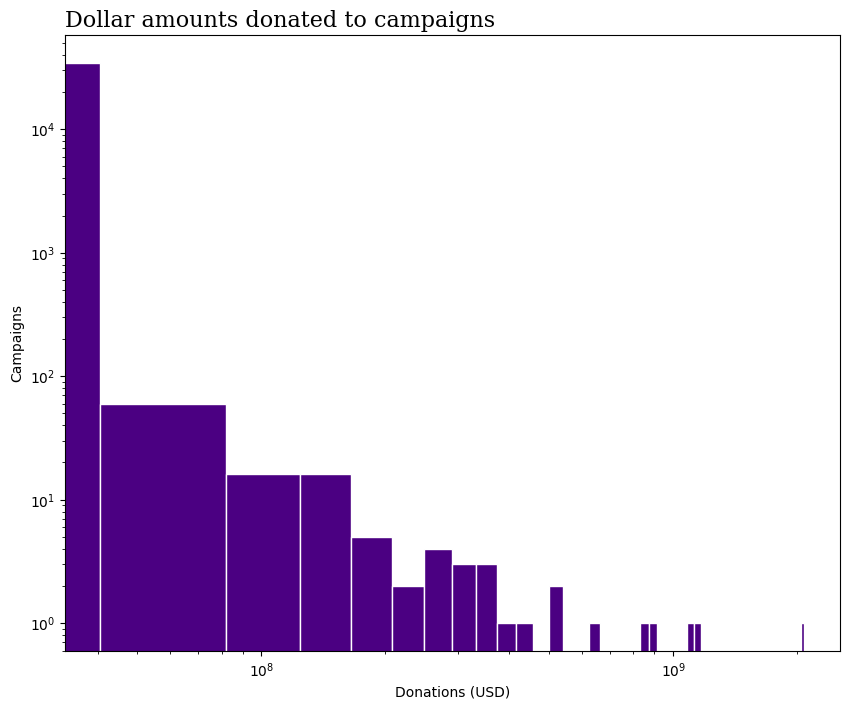

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
plt.hist(all_aggregated_donations['total_donations'], bins=50, edgecolor='white', color='indigo', label="Total Donations (USD)")

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Donations (USD)')
plt.ylabel('Campaigns')
plt.title('Dollar amounts donated to campaigns', loc='left',
font = {'family': 'serif',
        'weight': 'normal',
        'size': 16,
        });

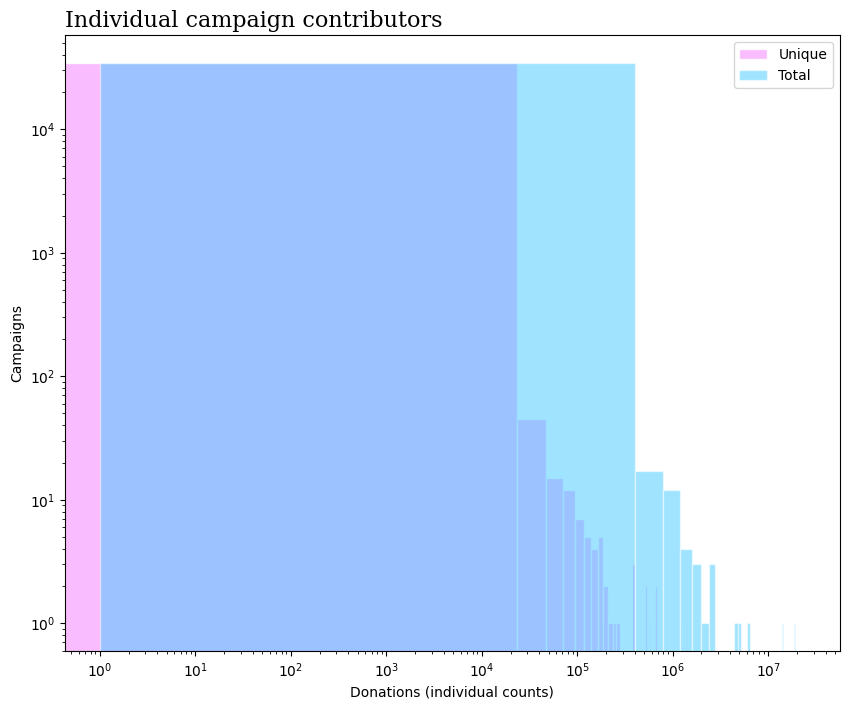

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
plt.hist(all_aggregated_donations['unique_donors'], bins=60, edgecolor='white', color='#f8acff', alpha=.8, label='Unique')
plt.hist(all_aggregated_donations['num_donations'], bins=60, edgecolor='white', color='#40c9ff', alpha=.5, label='Total')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Donations (individual counts)')
plt.ylabel('Campaigns')
plt.title('Individual campaign contributors', loc='left',
font = {'family': 'serif',
        'weight': 'normal',
        'size': 16,
        });

In [ ]:
merged_senate_races_df

,state,candidate,year,committee_id,party,result,vote_share,incumbent,total_donations,unique_donors,num_donations
0,AK,Lisa Murkowski,2022,C00384529,R,1,43.40,1,5470611.0,3491,6482
1,AK,Kelly Tshibaka,2022,C00774570,R,0,42.60,0,3708691.0,4606,12621
2,AZ,Mark Kelly,2022,C00696526,D,1,51.40,1,49436605.0,84539,647836
3,AZ,Blake Masters,2022,C00784165,R,0,46.50,0,9074038.0,8360,22549
4,GA,Raphael Warnock,2022,C00736876,D,1,49.40,1,101098954.0,175455,1079333
5,GA,Herschel Walker,2022,C00787853,R,0,48.50,0,35980445.0,45843,200938
6,NV,Catherine Cortez Masto,2022,C00575548,D,1,48.80,1,33812836.0,46645,303655
7,NV,Adam Laxalt,2022,C00787135,R,0,48.00,0,12044383.0,10585,51810
8,NH,Maggie Hassan,2022,C00588772,D,1,53.50,1,22312168.0,28652,128060
9,NH,Don Bolduc,2022,C00711010,R,0,44.40,0,1970529.0,2750,5777


In [ ]:
merged_senate_races_df.isna().sum()

,0
state,0
candidate,0
year,0
committee_id,0
party,0
result,0
vote_share,0
incumbent,0
total_donations,0
unique_donors,0


In [ ]:
import pandas as pd
from io import StringIO

data = """State,living_costs,disposable_income,average_salary,individual_contributions
Alabama,33654,19739,53393,706000
Alaska,48670,21219,69889,299459
Arizona,39856,23190,63046,2385000
Arkansas,32979,18273,51252,518000
California,53171,23790,76961,12427000
Colorado,45931,26038,71969,1853000
Connecticut,46912,26825,73737,978000
Delaware,44389,21610,65999,332708
Florida,40512,19704,60216,5836000
Georgia,38747,22509,61256,1913000
Hawaii,55491,9551,65042,387492
Idaho,37658,17982,55640,558000
Illinois,41395,25726,67121,2731000
Indiana,36207,20202,56409,984000
Iowa,35871,20539,56410,526000
Kansas,35185,21079,56264,572000
Kentucky,35508,18510,54018,575000
Louisiana,35576,17859,53435,678000
Maine,39899,20109,60008,460622
Maryland,48235,25397,73632,1744000
Massachusetts,53860,26470,80330,6497000
Michigan,37111,23479,60590,2165000
Minnesota,41498,25208,66706,1438000
Mississippi,32336,15233,47569,340690
Missouri,35338,22237,57575,1312000
Montana,37328,18582,55910,501000
Nebraska,37519,20555,58074,354560
Nevada,41630,17277,58907,878000
New Hampshire,45575,20527,66102,494682
New Jersey,49511,24474,73985,2016000
New Mexico,34501,23012,57513,721000
New York,49623,29001,78624,4724000
North Carolina,36702,23014,59716,1879000
North Dakota,35707,23345,59052,145443
Ohio,35932,23951,59883,2393000
Oklahoma,33966,19489,53455,783000
Oregon,46193,20512,66705,1604000
Pennsylvania,40066,21856,61922,2871000
Rhode Island,44481,22120,66601,252007
South Carolina,34826,19420,54246,1035000
South Dakota,36864,16363,53227,169432
Tennessee,34742,21293,56035,1275000
Texas,37582,23653,61235,6382000
Utah,40586,20483,61069,606000
Vermont,43927,18848,62775,267188
Virginia,43067,26987,70054,3177000
Washington,47231,30894,78125,2708000
West Virginia,34861,17346,52207,235394
Wisconsin,37374,22135,59509,1310000
Wyoming,37550,20377,57927,177563
"""

states_info = pd.read_csv(StringIO(data))

states_info.head()

,State,living_costs,disposable_income,average_salary,individual_contributions
0,Alabama,33654,19739,53393,706000
1,Alaska,48670,21219,69889,299459
2,Arizona,39856,23190,63046,2385000
3,Arkansas,32979,18273,51252,518000
4,California,53171,23790,76961,12427000


In [ ]:
state_code_mapping = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA',
    'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA',
    'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO',
    'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ',
    'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH',
    'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT',
    'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'
}

In [ ]:
states_info['State'] = states_info['State'].replace(state_code_mapping)
states_info.head()

,State,living_costs,disposable_income,average_salary,individual_contributions
0,AL,33654,19739,53393,706000
1,AK,48670,21219,69889,299459
2,AZ,39856,23190,63046,2385000
3,AR,32979,18273,51252,518000
4,CA,53171,23790,76961,12427000


In [ ]:
merged_senate_races_df.head()

,state,candidate,year,committee_id,party,result,vote_share,incumbent,total_donations,unique_donors,num_donations
0,AK,Lisa Murkowski,2022,C00384529,R,1,43.4,1,5470611.0,3491,6482
1,AK,Kelly Tshibaka,2022,C00774570,R,0,42.6,0,3708691.0,4606,12621
2,AZ,Mark Kelly,2022,C00696526,D,1,51.4,1,49436605.0,84539,647836
3,AZ,Blake Masters,2022,C00784165,R,0,46.5,0,9074038.0,8360,22549
4,GA,Raphael Warnock,2022,C00736876,D,1,49.4,1,101098954.0,175455,1079333


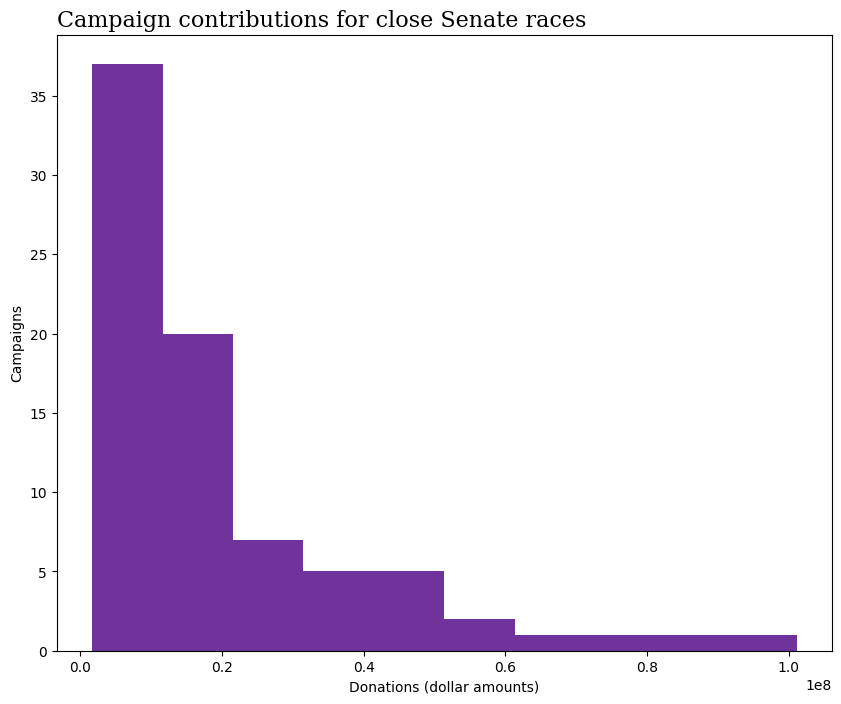

In [ ]:
plt.figure(figsize=(10,8))
plt.hist(merged_senate_races_df['total_donations'], bins=10, color='indigo', alpha=.8)
plt.xlabel('Donations (dollar amounts)')
plt.ylabel('Campaigns')
plt.title('Campaign contributions for close Senate races', loc='left',
font = {'family': 'serif',
        'weight': 'normal',
        'size': 16,
        });

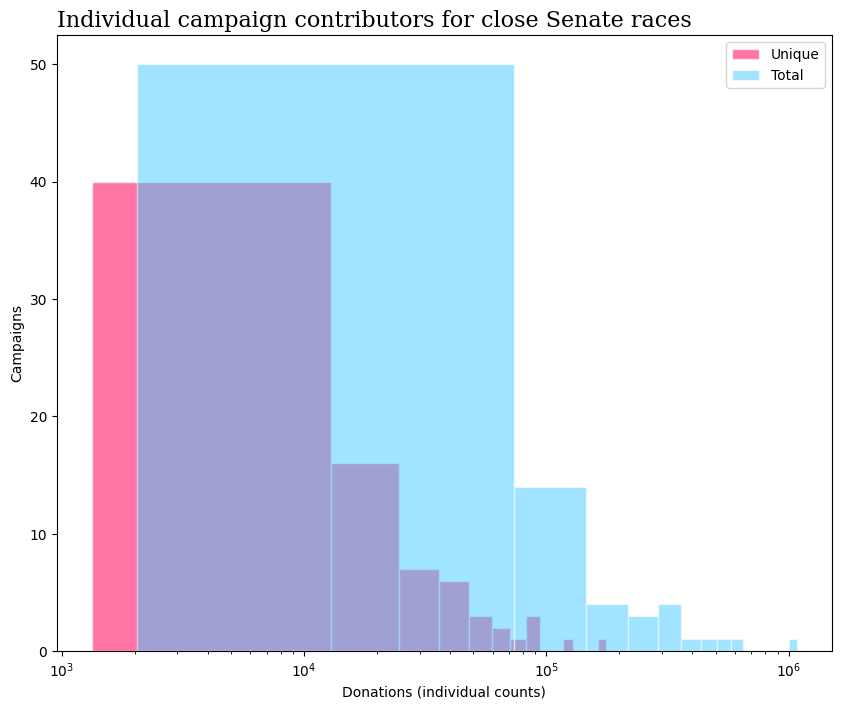

In [ ]:
plt.figure(figsize=(10,8))
plt.hist(merged_senate_races_df['unique_donors'], bins=15, edgecolor='white', color='#ff1b6b', alpha=.6, label='Unique')
plt.hist(merged_senate_races_df['num_donations'], bins=15, edgecolor='white', color='#45caff', alpha=.5, label='Total')
plt.legend()
plt.xscale('log')
plt.xlabel('Donations (individual counts)')
plt.ylabel('Campaigns')
plt.title('Individual campaign contributors for close Senate races', loc='left',
font = {'family': 'serif',
        'weight': 'normal',
        'size': 16,
        });

In [ ]:
merged_senate_races_df_states_info = merged_senate_races_df.merge(states_info, left_on='state', right_on='State', how='left')

print(merged_senate_races_df_states_info.head())

  state        candidate  year committee_id party  result  vote_share  \
0    AK   Lisa Murkowski  2022    C00384529     R       1        43.4   
1    AK   Kelly Tshibaka  2022    C00774570     R       0        42.6   
2    AZ       Mark Kelly  2022    C00696526     D       1        51.4   
3    AZ    Blake Masters  2022    C00784165     R       0        46.5   
4    GA  Raphael Warnock  2022    C00736876     D       1        49.4   

   incumbent  total_donations  unique_donors  num_donations State  \
0          1        5470611.0           3491           6482    AK   
1          0        3708691.0           4606          12621    AK   
2          1       49436605.0          84539         647836    AZ   
3          0        9074038.0           8360          22549    AZ   
4          1      101098954.0         175455        1079333    GA   

   living_costs  disposable_income  average_salary  individual_contributions  
0         48670              21219           69889                 

In [ ]:
merged_senate_races_df_states_info['donations_per_living_costs'] = merged_senate_races_df_states_info['total_donations']/merged_senate_races_df_states_info['living_costs']
merged_senate_races_df_states_info['donations_per_disp_income'] = merged_senate_races_df_states_info['total_donations']/merged_senate_races_df_states_info['disposable_income']
merged_senate_races_df_states_info['donations_per_salary'] = merged_senate_races_df_states_info['total_donations']/merged_senate_races_df_states_info['average_salary']


In [ ]:
merged_senate_races_df_states_info.head(0)

,state,candidate,year,committee_id,party,result,vote_share,incumbent,total_donations,unique_donors,num_donations,State,living_costs,disposable_income,average_salary,individual_contributions,donations_per_living_costs,donations_per_disp_income,donations_per_salary


In [ ]:
merged_senate_races_df_states_info.isna().sum()

,0
state,0
candidate,0
year,0
committee_id,0
party,0
result,0
vote_share,0
incumbent,0
total_donations,0
unique_donors,0


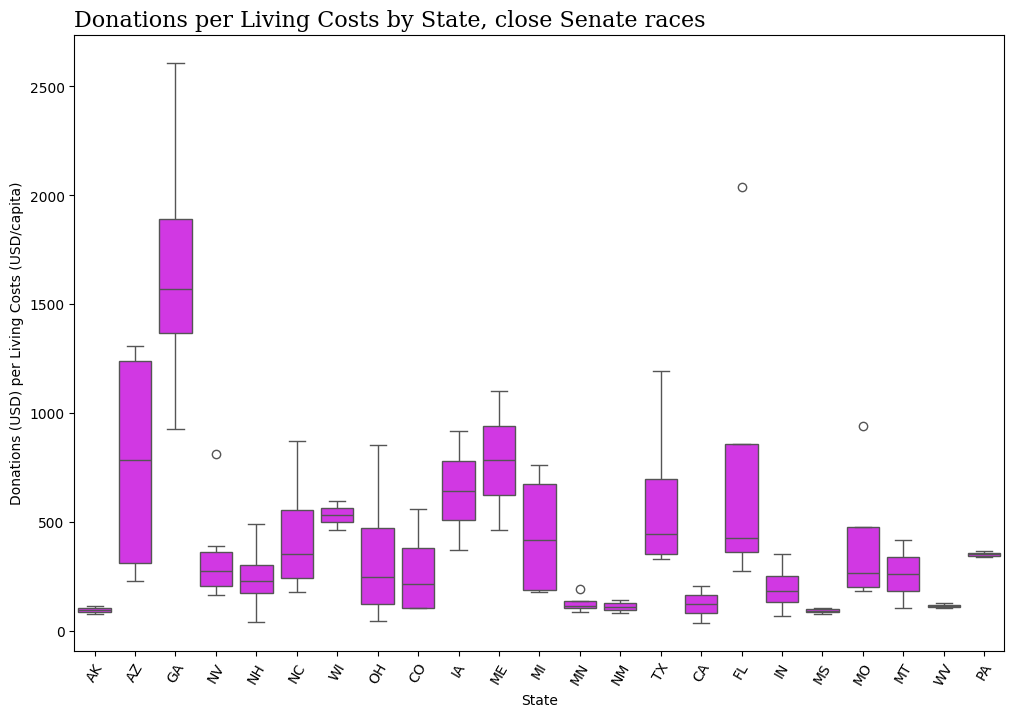

In [ ]:
plt.figure(figsize=(12, 8))

sns.boxplot(x='State', y='donations_per_living_costs', data=merged_senate_races_df_states_info, color='#e81cff')
plt.title('Donations per Living Costs by State, close Senate races', loc='left',font = {'family': 'serif',
        'weight': 'normal',
        'size': 16,
        })
plt.xlabel('State')
plt.ylabel('Donations (USD) per Living Costs (USD/capita)')
plt.xticks(rotation=60)

plt.show();

In [ ]:
merged_senate_races_df_states_info_cleaned = merged_senate_races_df_states_info.drop(columns=['committee_id', 'year', 'candidate', 'State', 'living_costs', 'disposable_income', 'average_salary', 'individual_contributions'])

In [ ]:
merged_senate_races_df_states_info_cleaned_dummified = pd.get_dummies(merged_senate_races_df_states_info_cleaned,
                                                         columns=[
                                                             'state',
                                                             'party',
                                                             'incumbent'],
                                                         drop_first=True)


In [ ]:
merged_senate_races_df_states_info_cleaned_dummified.head()

,result,vote_share,total_donations,unique_donors,num_donations,donations_per_living_costs,donations_per_disp_income,donations_per_salary,state_AZ,state_CA,...,state_NH,state_NM,state_NV,state_OH,state_PA,state_TX,state_WI,state_WV,party_R,incumbent_1
0,1,43.4,5470611.0,3491,6482,112.402116,257.816627,78.275709,False,False,...,False,False,False,False,False,False,False,False,True,True
1,0,42.6,3708691.0,4606,12621,76.200760,174.781611,53.065447,False,False,...,False,False,False,False,False,False,False,False,True,False
2,1,51.4,49436605.0,84539,647836,1240.380495,2131.807029,784.135473,True,False,...,False,False,False,False,False,False,False,False,False,True
3,0,46.5,9074038.0,8360,22549,227.670564,391.290987,143.927259,True,False,...,False,False,False,False,False,False,False,False,True,False
4,1,49.4,101098954.0,175455,1079333,2609.207268,4491.490248,1650.433492,False,False,...,False,False,False,False,False,False,False,False,False,True


In [ ]:
merged_senate_races_df_states_info_cleaned_dummified.head()

,result,vote_share,total_donations,unique_donors,num_donations,donations_per_living_costs,donations_per_disp_income,donations_per_salary,state_AZ,state_CA,...,state_NH,state_NM,state_NV,state_OH,state_PA,state_TX,state_WI,state_WV,party_R,incumbent_1
0,1,43.4,5470611.0,3491,6482,112.402116,257.816627,78.275709,False,False,...,False,False,False,False,False,False,False,False,True,True
1,0,42.6,3708691.0,4606,12621,76.200760,174.781611,53.065447,False,False,...,False,False,False,False,False,False,False,False,True,False
2,1,51.4,49436605.0,84539,647836,1240.380495,2131.807029,784.135473,True,False,...,False,False,False,False,False,False,False,False,False,True
3,0,46.5,9074038.0,8360,22549,227.670564,391.290987,143.927259,True,False,...,False,False,False,False,False,False,False,False,True,False
4,1,49.4,101098954.0,175455,1079333,2609.207268,4491.490248,1650.433492,False,False,...,False,False,False,False,False,False,False,False,False,True


In [ ]:
# setting up TTS
X = merged_senate_races_df_states_info_cleaned_dummified.drop(columns=['result', 'vote_share'])

In [ ]:
X.head()

,total_donations,unique_donors,num_donations,donations_per_living_costs,donations_per_disp_income,donations_per_salary,state_AZ,state_CA,state_CO,state_FL,...,state_NH,state_NM,state_NV,state_OH,state_PA,state_TX,state_WI,state_WV,party_R,incumbent_1
0,5470611.0,3491,6482,112.402116,257.816627,78.275709,False,False,False,False,...,False,False,False,False,False,False,False,False,True,True
1,3708691.0,4606,12621,76.200760,174.781611,53.065447,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,49436605.0,84539,647836,1240.380495,2131.807029,784.135473,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,9074038.0,8360,22549,227.670564,391.290987,143.927259,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,101098954.0,175455,1079333,2609.207268,4491.490248,1650.433492,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [ ]:
y = merged_senate_races_df_states_info_cleaned_dummified['result']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=420)


In [ ]:
X_train.isna().sum();

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
X_train_scaled.shape

(52, 30)

In [ ]:
# instantiating model

In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
# running model 1 (election outcome prediction)
history = model.fit(
    X_train_scaled, y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_test_scaled, y_test),
    callbacks=[early_stopping]
)

Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 280ms/step - accuracy: 0.4071 - loss: 1.2202 - val_accuracy: 0.3929 - val_loss: 0.7009
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6314 - loss: 0.9505 - val_accuracy: 0.3929 - val_loss: 0.7009
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4768 - loss: 0.8864 - val_accuracy: 0.4643 - val_loss: 0.7021
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5873 - loss: 0.8579 - val_accuracy: 0.4643 - val_loss: 0.7038
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5104 - loss: 0.9184 - val_accuracy: 0.4643 - val_loss: 0.7059
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4511 - loss: 1.0204 - val_accuracy: 0.4643 - val_loss: 0.7088
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5825 - loss: 0.8670 - val_accuracy: 0.4286 - val_loss: 0.7112
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5489 - loss: 0.8905 - val_accuracy: 0.4286 - val_loss

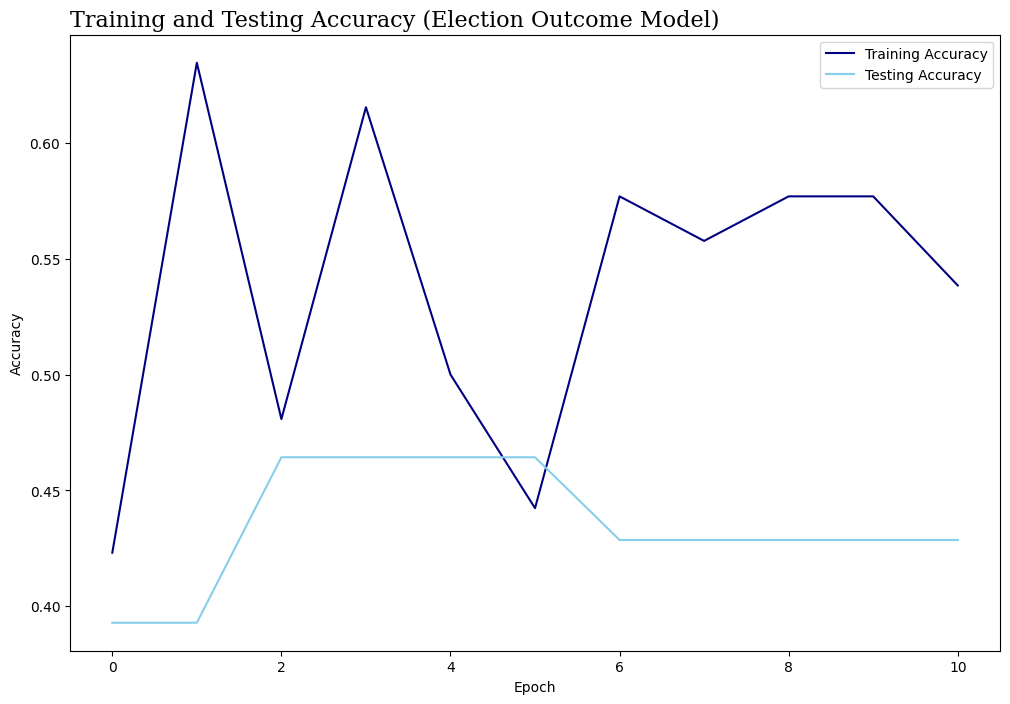

In [ ]:
train_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']

plt.figure(figsize=(12, 8))

plt.plot(train_accuracy, label='Training Accuracy', color='navy')
plt.plot(test_accuracy, label='Testing Accuracy', color='skyblue')
plt.legend()

plt.title('Training and Testing Accuracy (Election Outcome Model)', loc='left', fontdict={
    'family': 'serif',
    'weight': 'normal',
    'size': 16,
})

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
# setting up TTS for model_2 (vote share)

In [ ]:
X_2 = merged_senate_races_df_states_info_cleaned_dummified.drop(columns=['result', 'vote_share'])

In [ ]:
y_2 = merged_senate_races_df_states_info_cleaned_dummified['vote_share']

In [ ]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=420)

In [ ]:
scaler = StandardScaler()
X_train_scaled_2 = scaler.fit_transform(X_train_2)
X_test_scaled_2 = scaler.transform(X_test_2)

In [ ]:
# instantiating model 2 (linear)
model_2 = Sequential()
model_2.add(Dense(128, activation='relu', input_shape=(X_train_scaled_2.shape[1],)))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.5))
model_2.add(Dense(64, activation='relu'))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.5))
model_2.add(Dense(32, activation='relu'))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.5))
model_2.add(Dense(1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model_2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [ ]:
# fitting model 2
history_2 = model_2.fit(
    X_train_scaled_2, y_train_2,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_scaled_2, y_test_2),
    callbacks=[early_stopping]
)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 272ms/step - loss: 2382.6709 - mean_absolute_error: 48.6846 - val_loss: 2173.3867 - val_mean_absolute_error: 46.5502
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 2378.1179 - mean_absolute_error: 48.6132 - val_loss: 2175.0010 - val_mean_absolute_error: 46.5676
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 2417.1147 - mean_absolute_error: 49.0428 - val_loss: 2176.1926 - val_mean_absolute_error: 46.5804
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 2381.1614 - mean_absolute_error: 48.6762 - val_loss: 2177.1306 - val_mean_absolute_error: 46.5907
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 2394.3372 - mean_absolute_error: 48.7766 - val_loss: 2177.8557 - val_mean_absolute_error: 46.5987
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 2385.7971 - mean_absolute_error: 48.7341 - val_loss: 2179.1152 - val_mean_absolute_error: 46.6124
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 2360.

In [ ]:
test_loss_2, test_mae_2 = model_2.evaluate(X_test_scaled_2, y_test_2)
print(f'Test Mean Absolute Error: {test_mae_2:.2f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 2173.3867 - mean_absolute_error: 46.5502
Test Mean Absolute Error: 46.55


In [ ]:
y_pred_2 = model_2.predict(X_test_scaled_2)*100


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [ ]:
y_pred_2

array([[ 15.619978 ],
       [ 19.923052 ],
       [ 54.239822 ],
       [ 97.98877  ],
       [ 38.162918 ],
       [ 63.437088 ],
       [ -5.638148 ],
       [  4.9285927],
       [  5.7198176],
       [ 36.57659  ],
       [-14.358981 ],
       [ 24.457436 ],
       [ -3.2886467],
       [ 83.357544 ],
       [ 13.433949 ],
       [ 36.185722 ]], dtype=float32)

In [ ]:
y_test_2

,vote_share
78,48.80
7,48.00
17,48.80
20,50.61
33,45.62
21,49.39
68,52.10
55,46.78
0,43.40
19,44.20


,result,vote_share,total_donations,unique_donors,num_donations,donations_per_living_costs,donations_per_disp_income,donations_per_salary,state_AZ,state_CA,...,state_NH,state_NM,state_NV,state_OH,state_PA,state_TX,state_WI,state_WV,party_R,incumbent_1
0,1,43.4,5470611.0,3491,6482,112.402116,257.816627,78.275709,False,False,...,False,False,False,False,False,False,False,False,True,True
1,0,42.6,3708691.0,4606,12621,76.200760,174.781611,53.065447,False,False,...,False,False,False,False,False,False,False,False,True,False
2,1,51.4,49436605.0,84539,647836,1240.380495,2131.807029,784.135473,True,False,...,False,False,False,False,False,False,False,False,False,True
3,0,46.5,9074038.0,8360,22549,227.670564,391.290987,143.927259,True,False,...,False,False,False,False,False,False,False,False,True,False
4,1,49.4,101098954.0,175455,1079333,2609.207268,4491.490248,1650.433492,False,False,...,False,False,False,False,False,False,False,False,False,True


In [ ]:
y_pred_2 = model_2.predict(X_test_scaled_2).flatten()

y_pred_2 = y_pred_2 * 100

results_df = pd.DataFrame({
    'Index': range(len(y_test_2)),
    'Actual Vote Share': y_test_2,
    'Predicted Vote Share': y_pred_2
})

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


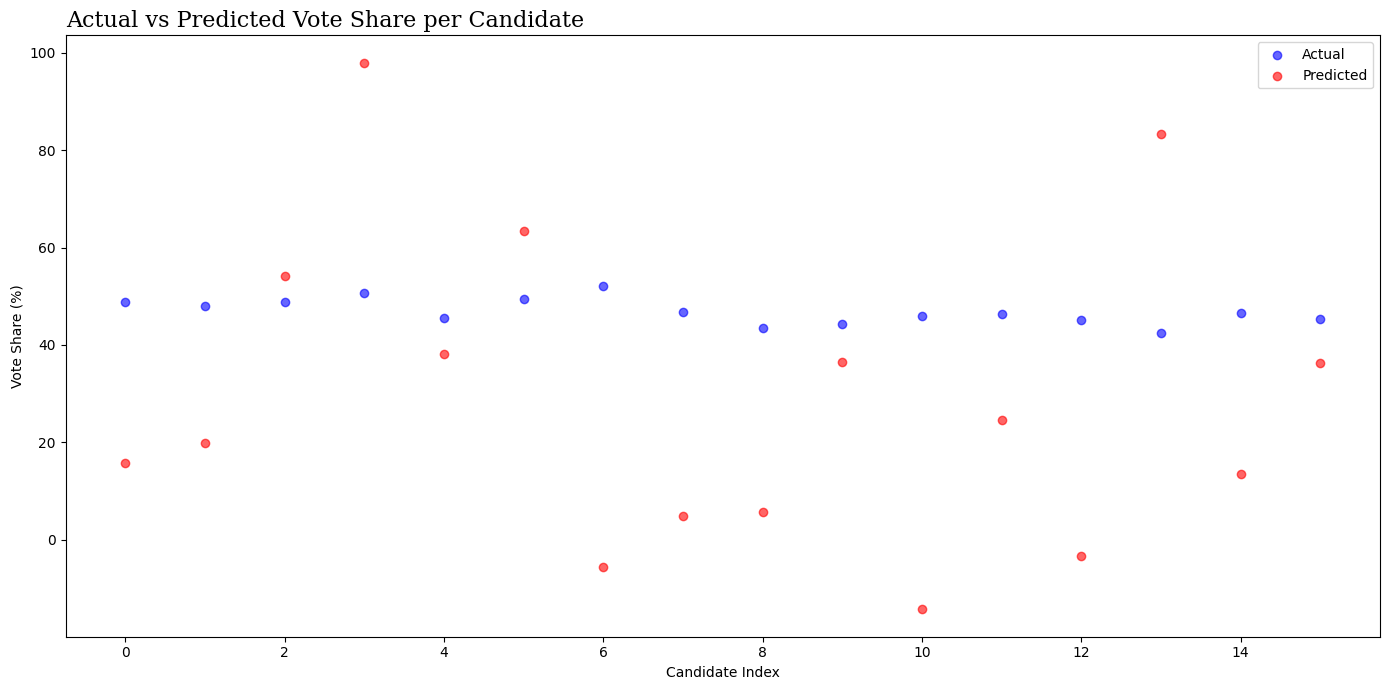

In [ ]:
plt.figure(figsize=(14, 7))

plt.scatter(results_df['Index'], results_df['Actual Vote Share'], color='blue', alpha=0.6, label='Actual')

plt.scatter(results_df['Index'], results_df['Predicted Vote Share'], color='red', alpha=0.6, label='Predicted')

plt.xlabel('Candidate Index')
plt.ylabel('Vote Share (%)')

plt.title('Actual vs Predicted Vote Share per Candidate', loc='left', fontdict={
    'family': 'serif',
    'weight': 'normal',
    'size': 16,
})

plt.legend()

plt.tight_layout()
plt.show()

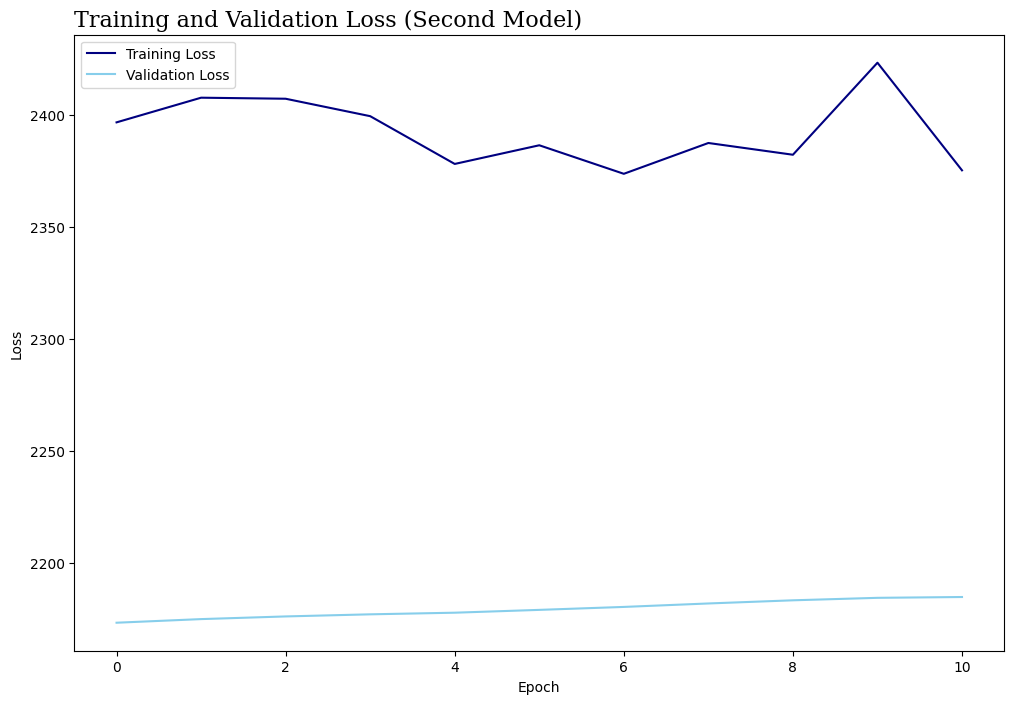

In [ ]:
train_loss_2 = history_2.history['loss']
val_loss_2 = history_2.history['val_loss']

plt.figure(figsize=(12, 8))

plt.plot(train_loss_2, label='Training Loss', color='navy')
plt.plot(val_loss_2, label='Validation Loss', color='skyblue')
plt.legend()

# Set the title with the specified parameters
plt.title('Training and Validation Loss (Second Model)', loc='left', fontdict={
    'family': 'serif',
    'weight': 'normal',
    'size': 16,
})

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()